# **Plots for Thesis Introduction**

#### In this notebook I plot the photometry and spectra of different types of supernovae for the introduction of my thesis.
#### I have downloaded *json* files with the SNe data from the open supernova catalog.

In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.time import Time

import warnings  # ignore some annoying warnings in some parts

#sns.set(font_scale=1.5, context='paper', style='white')
%config InlineBackend.figure_format = 'retina'
plt.rcParams["font.family"] = "Gentium"
plt.rcParams['mathtext.fontset'] = "cm"

# Functions

In [48]:
def extract_sn_from_json(sn_name):
    
    # load json file
    with open(f'{sn_name}.json') as f:
        sn_json = json.load(f)[sn_name] 

    # photometry
    sn_photometry = sn_json['photometry']
    phot_dict = {'mjd':[], 'band':[], 'mag':[], 'err':[]}

    for data in sn_photometry:
        if 'band' in data:
            if 'e_magnitude' in data:
                err = float(data['e_magnitude'])
            else:
                err = np.nan
            if 'system' in data:
                system = data['system']
            else:
                system = np.nan

            phot_dict['mjd'].append(float(data['time']))
            phot_dict['mag'].append(float(data['magnitude']))
            phot_dict['err'].append(err)
            phot_dict['band'].append(data['band'])

    phot_df = pd.DataFrame.from_dict(phot_dict)
    phot_df = phot_df.sort_values(['band', 'mjd'])

    # spectra
    sn_spectra = sn_json['spectra']
    spec_dict = {}

    for data in sn_spectra:
        time_dict = {}

        if 'time' in data:
            time = data['time']
        elif 'file_name' in data:
            time = data['file_name']
        else:
            time = 0.0

        spec = np.asarray(data['data']).T
        wave, flux = spec[0].astype(float), spec[1].astype(float)

        spec_dict['wave'] = wave
        spec_dict['flux'] = flux
        spec_dict['units'] = data['u_fluxes']
        spec_dict['ref'] = data['source']

        spec_dict[time] = time_dict
        
    return sn_json, phot_df, spec_dict

def average_in_time(mag, time, dt):
    
    y = []
    x = np.arange(time.min(), time.max()+dt, dt)
    
    for t in x:
        mask = np.abs(time-t)<dt
        if len(mag[mask])>0:
            mean = mag[mask].mean()
        else:
            mean = np.nan
        y.append(mean)
    y = np.array(y)
    
    return x, y
    
def plot_phot(phot_df, band='B', dt=0.5, mu=10, text=None):

    fig, ax = plt.subplots(figsize=(12, 8))
    ax2 = ax.twinx()

    band_df = phot_df[phot_df.band==band]
    time, mag = band_df.mjd.values, band_df.mag.values
    tmax = time[mag.argmin()]

    x, y = average_in_time(mag, time-tmax, dt)
    time_mask = (x>=-15) & (x<=40)
    
    nan_mask = ~np.isnan((y-mu)[time_mask])
    X, Y = x[time_mask][nan_mask], (y-mu)[time_mask][nan_mask]

    ax.plot(X, Y+mu, lw=6)
    ax2.plot(X, Y, color='darkmagenta', lw=6)
    
    if text is not None:
        ax2.text(X.max()-20, Y.min()+0.5, text, fontsize=26, color='darkmagenta')

    ax.set_xlabel(f'Phase with respect to {band}-band max. (days)', fontsize=20)
    ax.set_ylabel(f'Apparent {band}-band Magnitude', fontsize=20)
    ax.tick_params('both', labelsize=20, direction='in', length=5)
    #ax.set_xlim(-16, 41)
    #ax.set_ylim(9.5, 14)
    #ax2.set_ylim(9.5-mu, 14-mu)
    ax.invert_yaxis()

    ax2.set_ylabel(f'Absolute {band}-band Magnitude', fontsize=20, rotation=270, labelpad=20) 
    ax2.tick_params('both', labelsize=20, direction='in', length=8)
    ax2.invert_yaxis()

    plt.savefig('plots/snia_photometry.pdf', bbox_inches='tight')
    plt.show()
    
def plot_multi_phot(phot_df_list, band='B', dt=0.5, mu_list=None, sn_names=None):

    fig, ax = plt.subplots(figsize=(12, 8))

    for phot_df, mu, sn_name in zip(phot_df_list, mu_list, sn_names):
        band_df = phot_df[phot_df.band==band]
        time, mag = band_df.mjd.values, band_df.mag.values
        tmax = time[mag.argmin()]
        print(tmax)

        x, y = average_in_time(mag, time-tmax, dt)
        time_mask = (x>=-20) & (x<=145)

        nan_mask = ~np.isnan((y-mu)[time_mask])
        X, Y = x[time_mask][nan_mask], (y-mu)[time_mask][nan_mask]
        
        ax.plot(X, Y, marker='o', ms=10, ls='--', label=sn_name)

    ax.set_xlabel(f'Phase with respect to {band}-band max. (days)', fontsize=20)
    ax.set_ylabel(f'Absolute {band}-band Magnitude', fontsize=20) 
    ax.tick_params('both', labelsize=20, direction='in', length=5)
    #ax.set_xlim(-16, 41)
    #ax.set_ylim(9.5, 14)
    #ax2.set_ylim(9.5-mu, 14-mu)
    ax.invert_yaxis()
    ax.legend(fontsize=18)

___
## SN 2011fe

### Spectrum

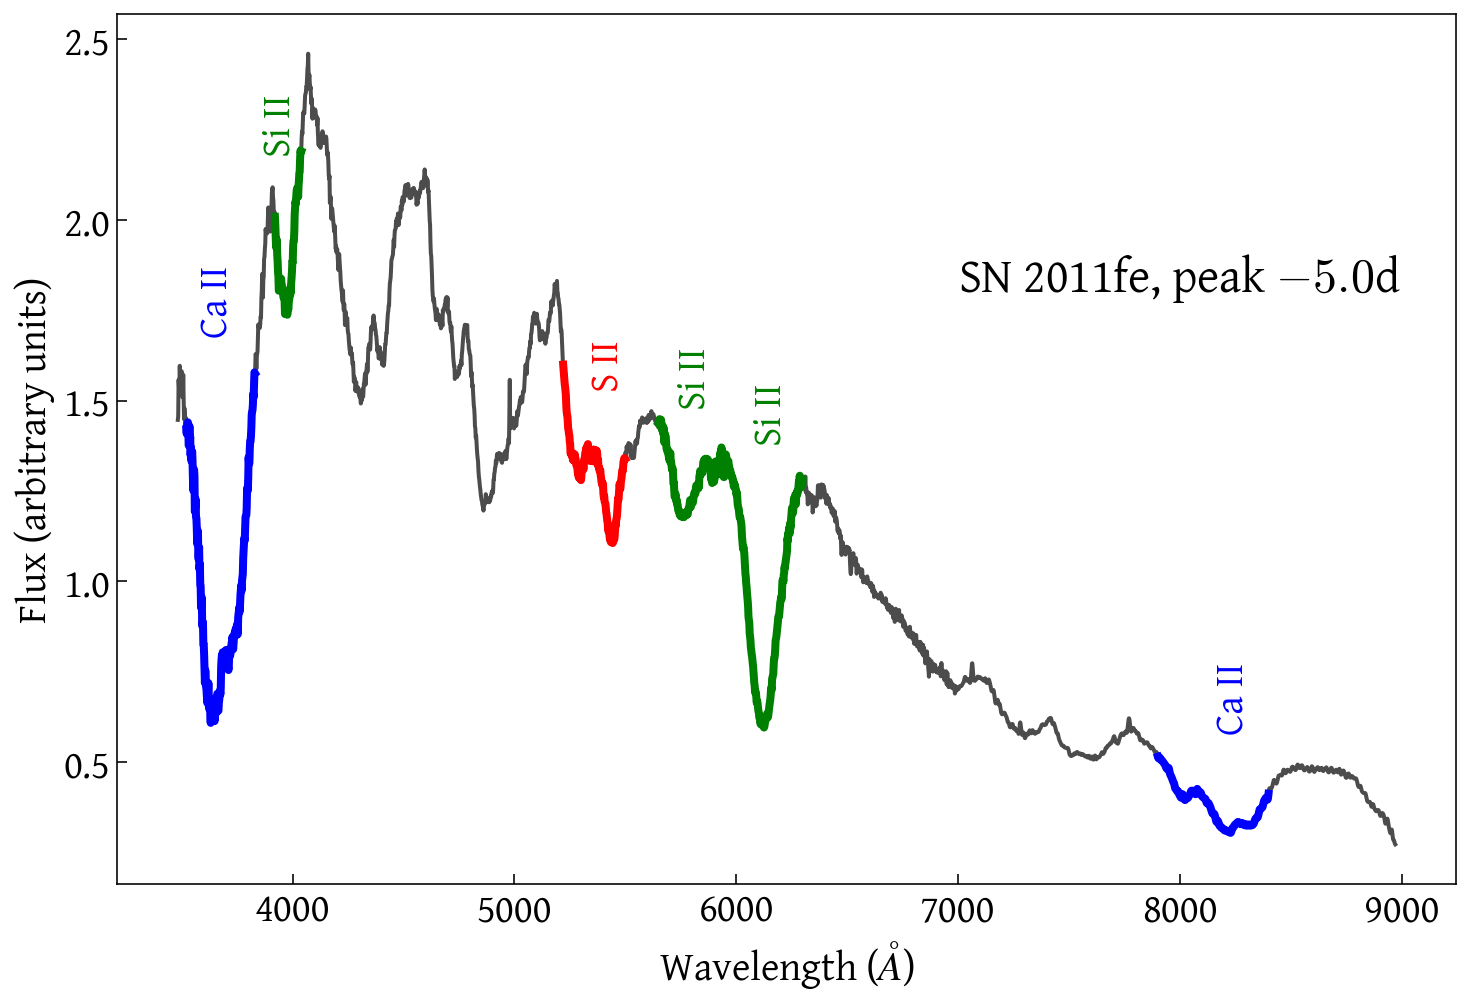

In [4]:
wave, flux = np.loadtxt('SN2011fe_2011-09-01_00-00-00_Lijiang-2.4m_YFOSC_None.txt').T
norm = 1e-13
flux /= norm
lw = 4

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(wave, flux, lw=2, color='k', alpha=0.7)

mask = (wave >= 3520) & (wave <= 3830)
ax.plot(wave[mask], flux[mask], lw=lw, color='blue')
mask = (wave >= 7900) & (wave <= 8400)
ax.plot(wave[mask], flux[mask], lw=lw, color='blue')

mask = (wave >= 3920) & (wave <= 4040)
ax.plot(wave[mask], flux[mask], lw=lw, color='green')
mask = (wave >= 5650) & (wave <= 6300)
ax.plot(wave[mask], flux[mask], lw=lw, color='green')

mask = (wave >= 5220) & (wave <= 5500)
ax.plot(wave[mask], flux[mask], lw=lw, color='red')

# spectral features tags
ax.text(3570, 1.7, 'Ca II', rotation=90, fontsize=20, color='blue')
ax.text(8150, 0.6, 'Ca II', rotation=90, fontsize=20, color='blue')

ax.text(3850, 2.2, 'Si II', rotation=90, fontsize=20, color='green')
ax.text(5720, 1.5, 'Si II', rotation=90, fontsize=20, color='green')
ax.text(6060, 1.4, 'Si II', rotation=90, fontsize=20, color='green')

ax.text(5330, 1.55, 'S II', rotation=90, fontsize=20, color='red')

ax.text(7000, 1.8, r'SN 2011fe, peak $-5.0$d', fontsize=24, color='k')

ax.set_xlabel(r'Wavelength ($\AA$)', fontsize=20)
ax.set_ylabel(r'Flux (arbitrary units)', fontsize=20)
ax.tick_params('both', labelsize=20, direction='in', length=5)

#plt.savefig('plots/snia_spectrum.pdf', bbox_inches='tight')
plt.show()

### Photometry

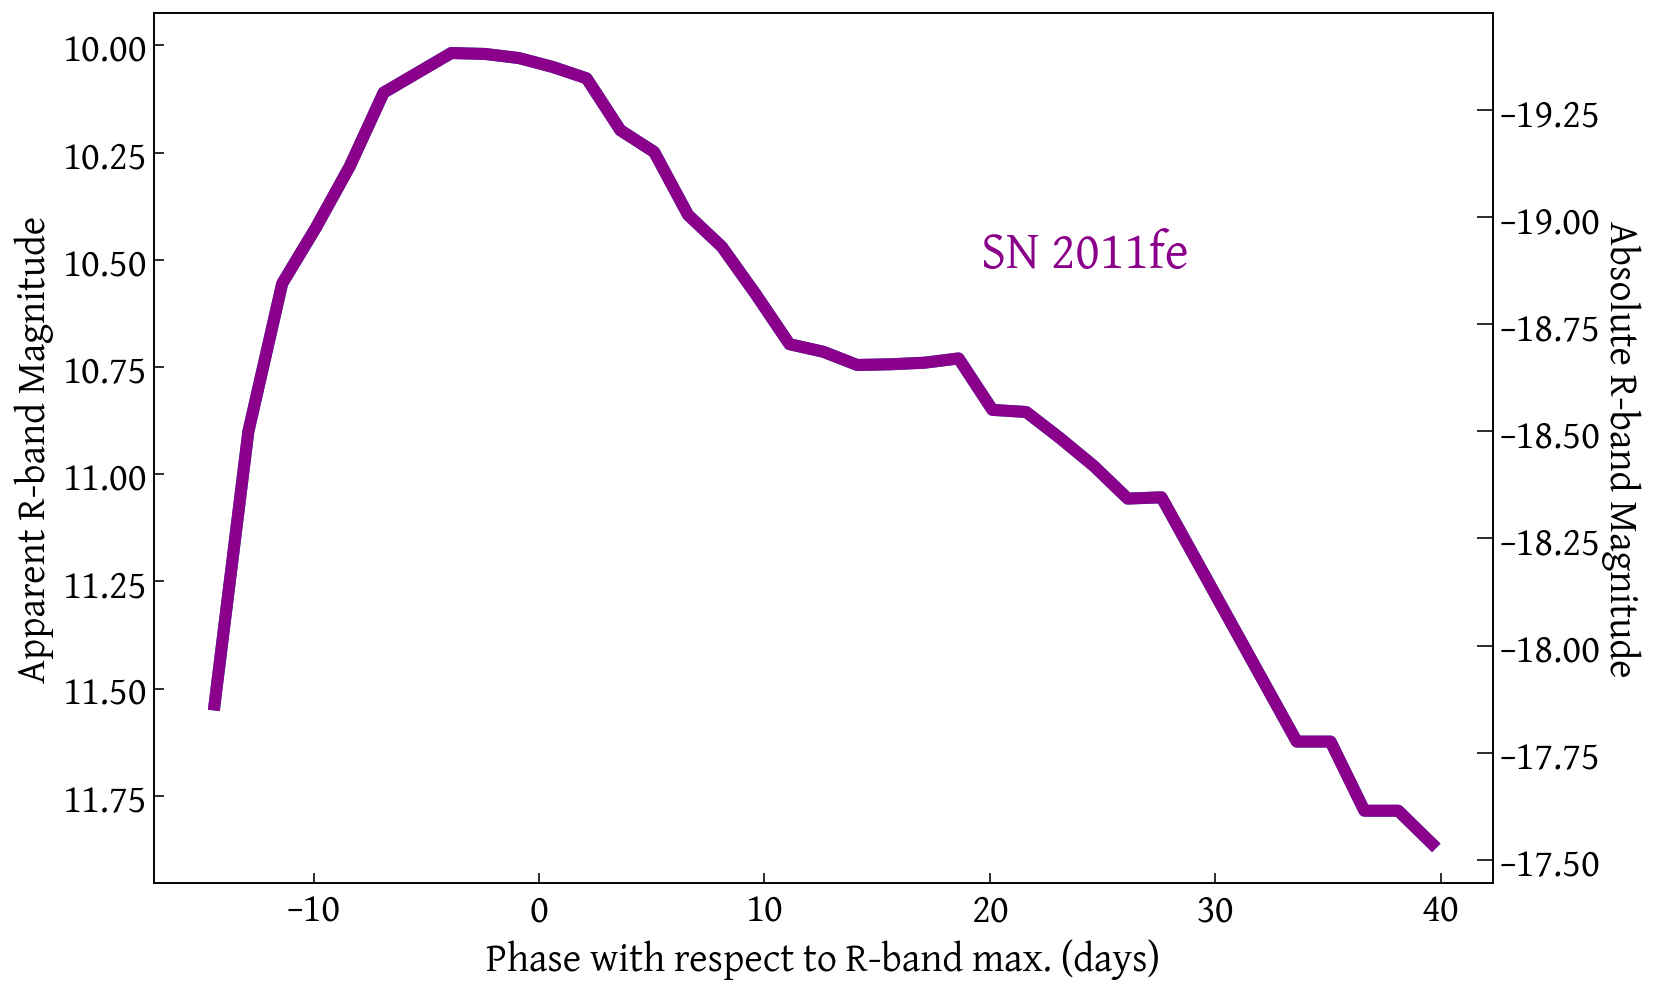

In [5]:
sn_name = 'SN2011fe'
sn_json, phot_df, spec_dict = extract_sn_from_json(sn_name)

plot_phot(phot_df, band='R', dt=1.5, mu=29.4, text='SN 2011fe')

In [6]:
def plot_full_phot(phot_df, bands=None, dt=0.5, offsets=None, text=None):

    fig, ax = plt.subplots(figsize=(12, 8))

    if bands is None:
        bands = phot_df.band.unique()
    if offsets is None:
        offsets = [0]*len(bands)
        
    for band, off in zip(bands, offsets):
        band_df = phot_df[phot_df.band==band]
        time, mag = band_df.mjd.values, band_df.mag.values + off
        tmax = time[mag.argmin()]

        x, y = average_in_time(mag, time-tmax, dt)
        time_mask = (x>=-15) & (x<=60)

        nan_mask = ~np.isnan(y[time_mask])
        X, Y = x[time_mask][nan_mask], y[time_mask][nan_mask]

        ax.plot(X, Y, marker='o', ms=10, ls='', label=f'{band} + {off:.1f}')
    
    if text is not None:
        ax.text(X.max()-25, Y.min()+2.5, text, fontsize=30, color='k')

    ax.set_xlabel(r'Phase with respect to $B$-band max. (days)', fontsize=20)
    ax.set_ylabel(f'Apparent Magnitude', fontsize=20)
    ax.tick_params('both', labelsize=20, direction='in', length=5)
    ax.invert_yaxis()
    ax.legend(fontsize=18)

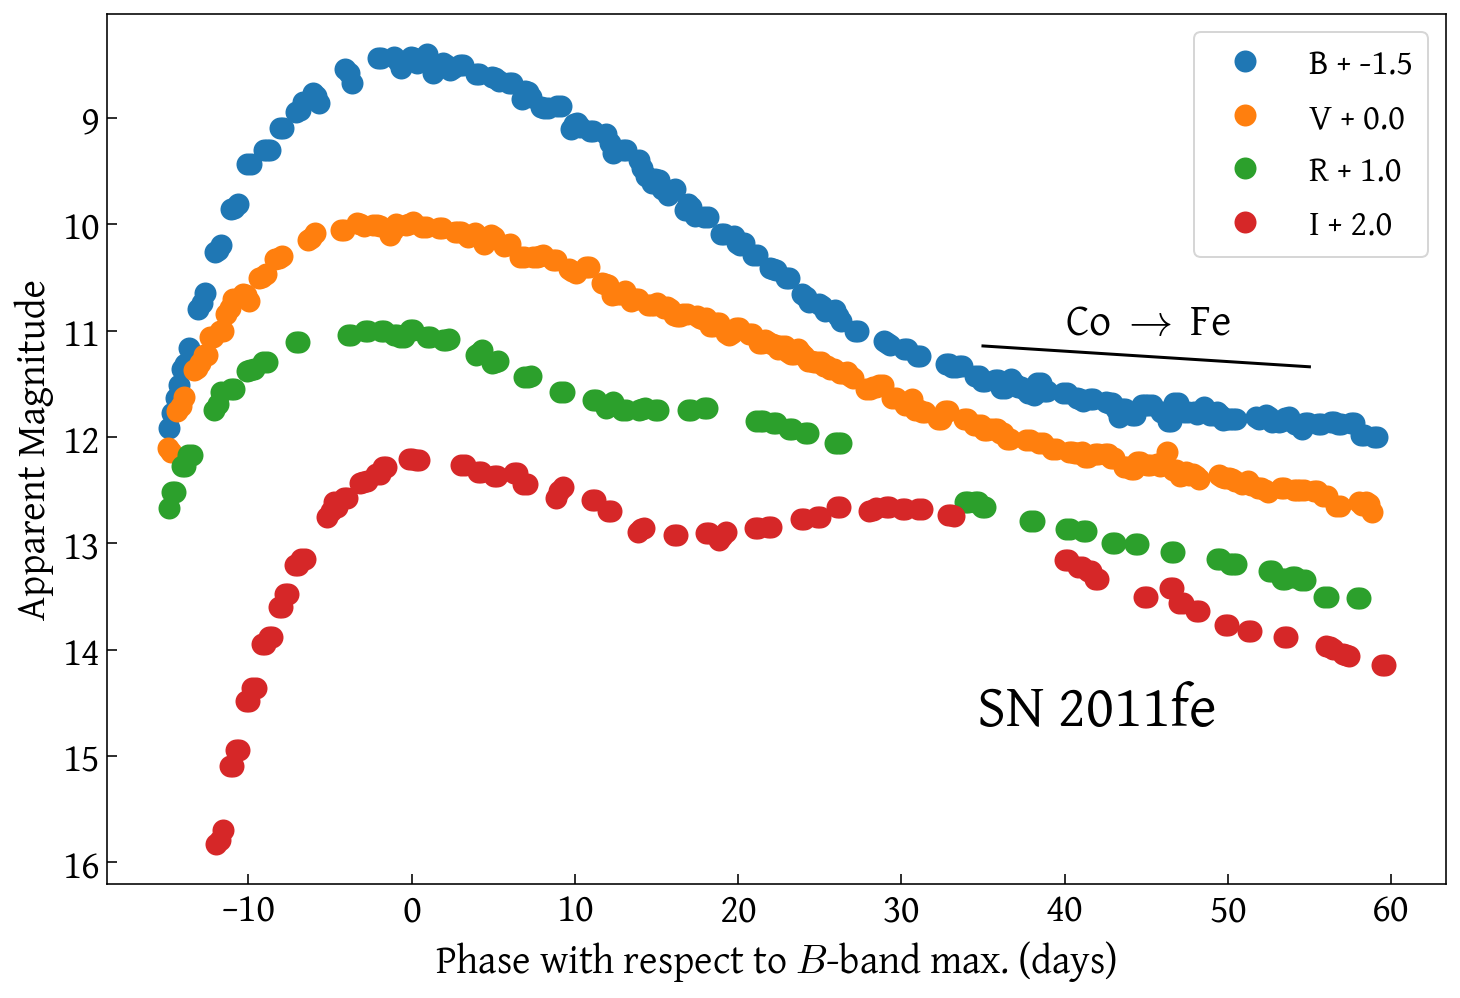

In [7]:
sn_name = 'SN2011fe'
sn_json, phot_df, spec_dict = extract_sn_from_json(sn_name)

bands = ['B', 'V', 'R', 'I']
#bands=None
offsets = [-1.5, 0, 1, 2]

plot_full_phot(phot_df, bands, dt=0.2, offsets=offsets, text='SN 2011fe')

time = np.array([35, 55])
co_decay = 0.98*time/100 + 10.8
plt.plot(time, co_decay, 'k')
plt.text(time.min() + 5, co_decay.max()-0.3, r'Co $\rightarrow$ Fe', fontsize=22, color='k')

plt.savefig('plots/snia_photometry.pdf', bbox_inches='tight')
plt.show()

___
## Core-Collapse SNe

II-L: 13ej, 14G, 99em, 04et
Ib: 07Y iPTF13bvn

In [62]:
#sn_names = ['SN2007Y', 'SN2007gr', 'SN2004et', 'SN1980K']
sn_names = ['iPTF13bvn', 'SN2007gr', 'SN2013fs', 'SN2014G']

phot_df_list = []
spec_dict_list = []
json_list = []
redshifts = []
tmax_list = []
mu_list = []

for sn_name in sn_names:
    sn_json, phot_df, spec_dict = extract_sn_from_json(sn_name)
    
    json_list.append(sn_json)
    phot_df_list.append(phot_df)
    spec_dict_list.append(spec_dict)
    
    z = sn_json['redshift'][0]['value']
    redshifts.append(float(z))
    
    date = sn_json['maxdate'][0]['value']
    t = Time(date.replace('/', '-'))
    tmax_list.append(t.mjd)
    
    max_app_mag = float(sn_json['maxvisualappmag'][0]['value'])
    max_abs_mag = float(sn_json['maxvisualabsmag'][0]['value'])
    mu_list.append(max_app_mag - max_abs_mag)

### Photometry

In [63]:
# there are two V-bands for SN 2004et with different clibrations, so I remove one
#phot_df_list[2] = phot_df_list[2][phot_df_list[2].mag > 12.2]

56477.2
54338.03
56577.3198
56679.9658


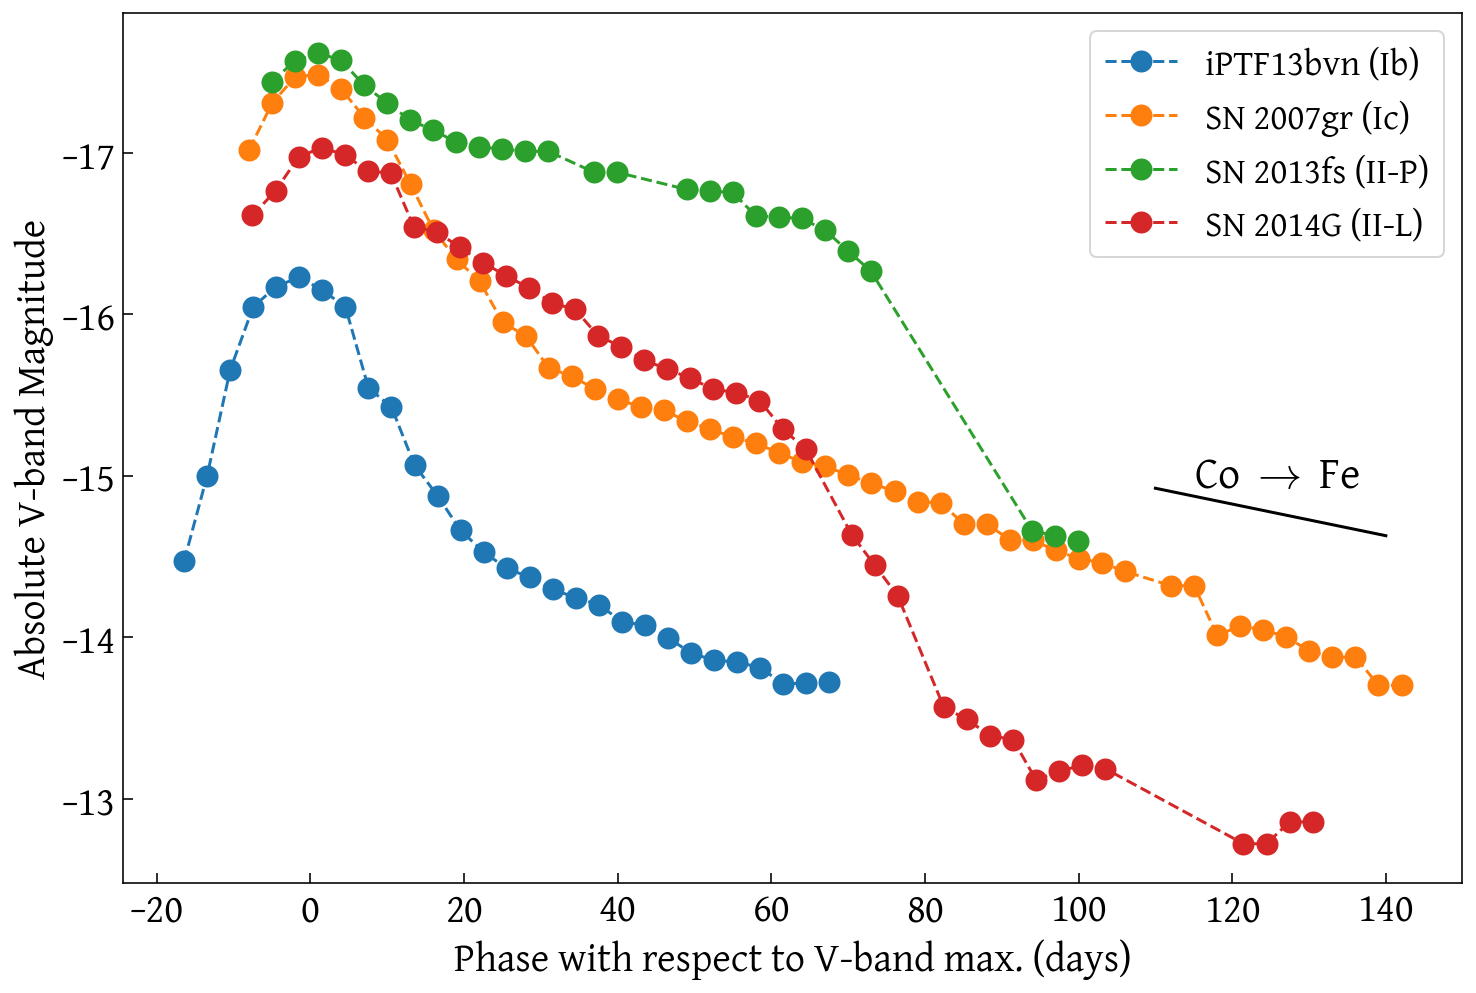

In [67]:
labels = []
types = ['Ib', 'Ic', 'II-P', 'II-L']
for name, sntype in zip(sn_names, types):
    if 'SN' in name:
        label = f'{name[:2]} {name[2:]} ({sntype})'
    else:
        label = f'{name} ({sntype})'
    labels.append(label)

plot_multi_phot(phot_df_list, band='V', dt=3, mu_list=mu_list, sn_names=labels)

# Co decay
time = np.array([110, 140])
co_decay = 0.98*time/100 - 16
plt.plot(time, co_decay, 'k')
plt.text(time.min() + 5, co_decay.max()-0.3, r'Co $\rightarrow$ Fe', fontsize=22, color='k')

#plt.savefig('plots/ccsne_photometry.pdf', bbox_inches='tight')
plt.show()

### Spectra

In [65]:
waves, fluxes = [], []
spec_phases = []
phases = [5, 5, 60, 50]

for i, phase in enumerate(phases):

    time = tmax_list[i] + phase

    times = np.array([float(spec['time']) for spec in json_list[i]['spectra']])
    mask = np.argmin(np.abs(times-time))

    spec_time = times[mask]
    spec_data = np.array(json_list[i]['spectra'][mask]['data']).T
    spec_data = spec_data.astype(np.float)

    try:
        wave, flux = spec_data
    except:
        wave, flux, flux_err = spec_data
    waves.append(wave)
    fluxes.append(flux)
    spec_phases.append(spec_time-tmax_list[i])

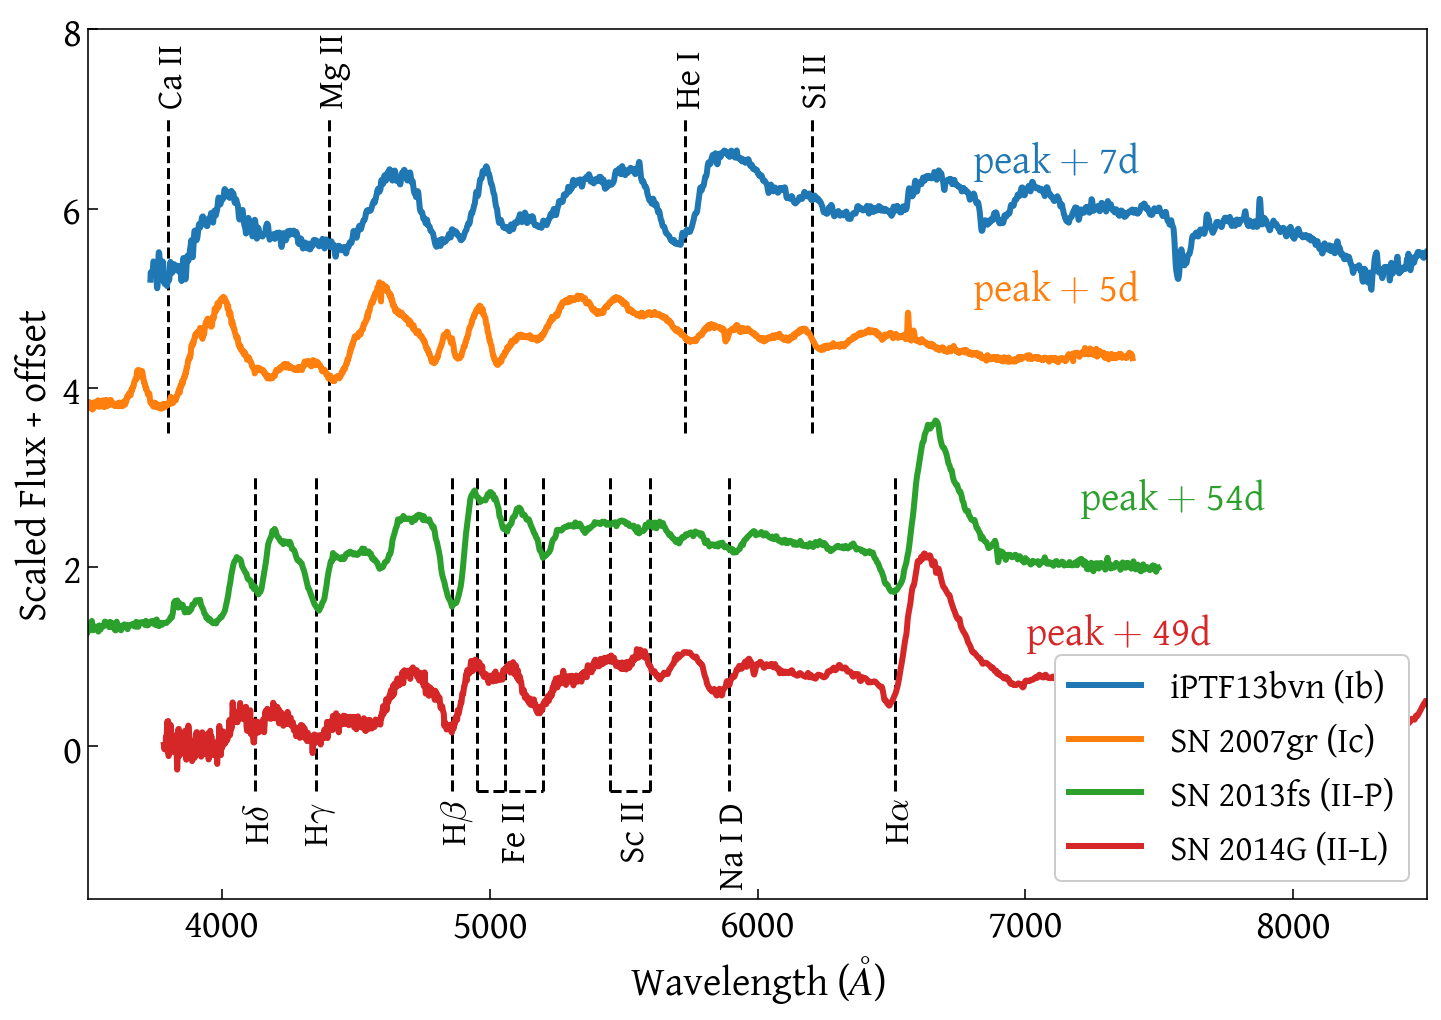

In [68]:
norms = [5e-18, 1e-16, 0.2, 1e-16]  # normalisation for the spectra
offsets = [5, 3.5, 1.2, -0.3] # y-axis offset for the spectra
xoff = [0, 0, 100, 100]  # x-axis offset for the spectra

phase_xs = [6800, 6800, 7200, 7000]  # where to put the phase text

fig, ax = plt.subplots(figsize=(12, 8))

# spectra
for wave, flux, off, xo, sn_name, z, phase, px in zip(waves, fluxes, offsets, xoff, labels, redshifts, spec_phases, phase_xs):
    mask = (wave>=3500) & (wave<=7000)
    norm = np.mean(flux[mask])
    bs = ax.plot(wave/(1+z) + xo, flux/norm + off, label=sn_name, lw=3)
    
    if phase >= 0:
         phase_text = r'peak $+$' + f' {phase:.0f}d'
    else:
         phase_text = r'peak $-$' + f' {-phase:.0f}d'
    ax.text(px, (flux/norm + off).mean()+0.5, phase_text, fontsize=20, color=bs[0].get_color())
    
# lines
lines_fontsize = 18

# H-rich CCSNe
lines_hrich = {'Ca II':[3800],
              'He I':[5730],
               'Mg II':[4400],
              'Si II':[6203],
              #'O I':[7530]
}

for line_name, lines in lines_hrich.items():
    for w in lines:
        ax.vlines(w, 3.5, 7, ls='--', color='k')
        ax.text(w-50, 7.2, line_name, rotation=90, fontsize=lines_fontsize)

        
# H-poor CCSNe
lines_hpoor = {'Fe':[4924+30, 5108-50, 5169+30],
              'H':[6563-50, 4861, 4340+10, 4102+20],
               'Na I D':[5895],
               'Sc II':[5450, 5600]
}
H_list = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
ih = 0

for line_name, lines in lines_hpoor.items():
    if line_name=='Fe':
        line_name = ' '
        ax.hlines(-0.5, lines[0], lines[-1], ls='--', color='k')
        mean_fe = (lines[0]+lines[-1])/2.
        ax.text(mean_fe-50, -1.2, 'Fe II', rotation=90, fontsize=lines_fontsize)
        
    if line_name=='Sc II':
        line_name = ' '
        ax.hlines(-0.5, lines[0], lines[-1], ls='--', color='k')
        mean_fe = (lines[0]+lines[-1])/2.
        ax.text(mean_fe-50, -1.2, 'Sc II', rotation=90, fontsize=lines_fontsize)
            
    for w in lines:
        off = 0
        if 'H' in line_name:
            line_name = line_name[0] + H_list[ih]
            ih += 1
        if 'Na I D' in line_name:
            off = -0.5
        ax.vlines(w, -0.5, 3, ls='--', color='k')
        ax.text(w-50, -1+off, line_name, rotation=90, fontsize=lines_fontsize)
    
    
ax.set_xlabel(r'Wavelength ($\AA$)', fontsize=20)
ax.set_ylabel(r'Scaled Flux + offset', fontsize=20)
ax.tick_params('both', labelsize=20, direction='in', length=5)
ax.legend(fontsize=18, framealpha=1, loc='lower right')
ax.set_xlim(3500, 8500)
ax.set_ylim(-1.7, 8)

#plt.savefig('plots/ccsne_spectra.pdf', bbox_inches='tight')
plt.show()

___